# Project: Build a Traffic Sign Recognition Classifier
## By Xi Chen 

This file only contains the answer part of the project, since the writing from the original document is very lengthy and hard to find what I have done.

In [1]:
#%%bash
#unzip traffic-signs-data.zip

import pickle
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

---
## Step 0: Load The Data

In [2]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

SignName = pd.read_csv('signnames.csv')['SignName']

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

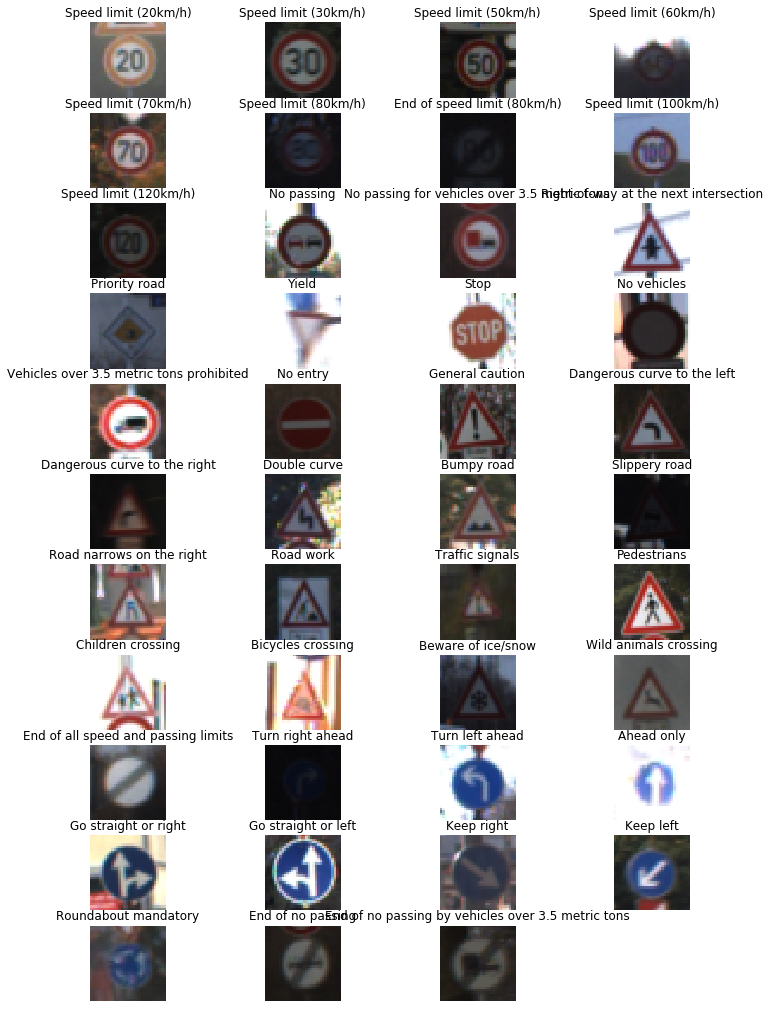

In [47]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.

np.random.seed(111)
image_indx = [(lambda x: random.choice(*np.where(y_train==x)))(i) for i in range(0,n_classes)]
# print(image_indx)
plt.figure(figsize=(12, 18))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    plt.imshow(X_train[image_indx[i]])
    plt.title(SignName[i])
    plt.axis('off')
plt.show()

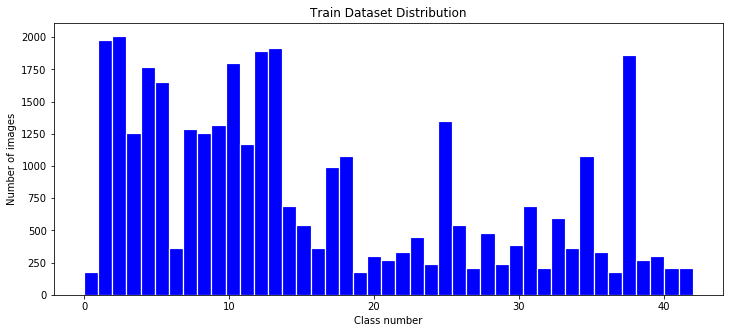

In [17]:
plt.figure(figsize=(12, 5))
plt.hist(y_train, bins=43, color='blue', edgecolor='white', linewidth=1.2)
plt.title("Train Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

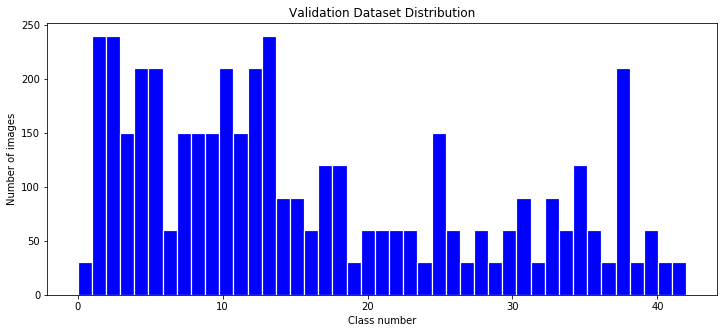

In [48]:
plt.figure(figsize=(12, 5))
plt.hist(y_valid, bins=43, color='blue', edgecolor='white', linewidth=1.2)
plt.title("Validation Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

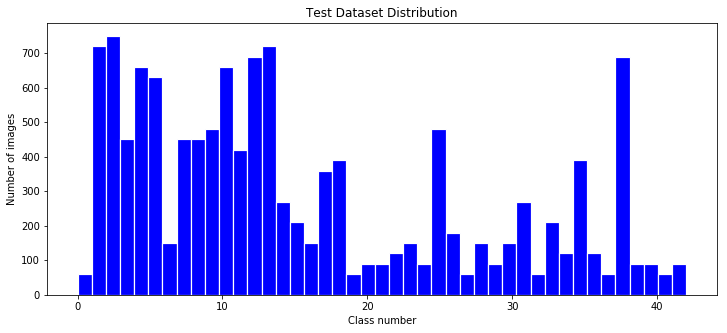

In [49]:
plt.figure(figsize=(12, 5))
plt.hist(y_test, bins=43, color='blue', edgecolor='white', linewidth=1.2)
plt.title("Test Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

<font color='green'> From the above histogram, it shows that the data is very unbalanced, which could cause some issues, I have not decided whether to truncate the data to the same number or to use data augumentation to increase the dataset to the same size.<font>

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set
#### 1. Normalization 

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [4]:
def img_normalize(img):
    """Applies the Normalization
    This will return an image after normalization with formula:
    (pixel - 128)/ 128. 
    """
    return (img - 128)/128

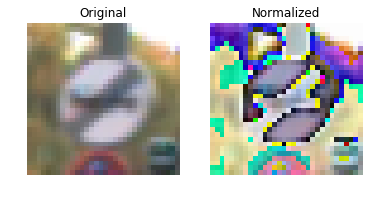

In [62]:
X_train_processed = []
for i in range(0, n_train):
    X_train_processed.append(img_normalize(X_train[i]))
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_train_processed[100])
plt.title("Normalized")
plt.axis('off')
plt.show()

#### 2. Grayscale

In [27]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    img=img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

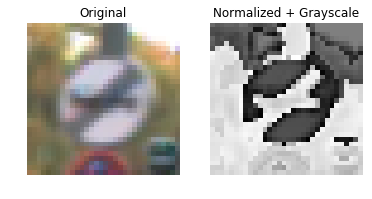

In [65]:
X_train_processed = []
for i in range(0, n_train):
    X_train_processed.append(grayscale(img_normalize(X_train[i])))
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_train_processed[100], cmap = "gray")
plt.title("Normalized + Grayscale")
plt.axis('off')
plt.show()

<font color='green'> I have read a lot about how to process the image, one thing I noticed is not a lot on the first two image process methods. One reason why no one would like to grayscale the image is the belief that color would add another features.<font>

#### 3. Cropping Image
<font color='green'> From the observation, most images have at least some region which is not useful, I think cropping image to a smaller size, might increase the train speed.<font>

In [5]:
def crop(img, crop_val=0):
    img = img[crop_val:img.shape[0]-crop_val,crop_val:img.shape[1]-crop_val]
    return img

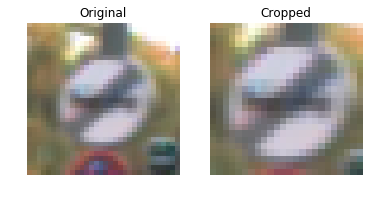

Original size  (32, 32, 3)
Cropped size  (24, 24, 3)


In [70]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(crop(X_train[100], 4))
plt.title("Cropped")
plt.axis('off')
plt.show()
print("Original size ", X_train[100].shape)
print("Cropped size ", crop(X_train[100], 4).shape)

#### 4. Histogram Equalization
<font color='green'>Increase the contrast of the images with the cv2.equalizeHist function.<font>

In [6]:
def Histogram_Equalization(img):
    img_new=img.copy() 
    img_new[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img_new[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img_new[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img_new

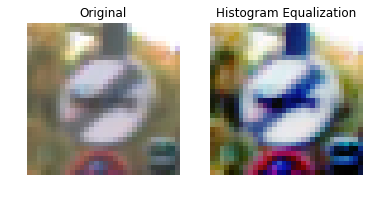

In [72]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Histogram_Equalization(X_train[100]))
plt.title("Histogram Equalization")
plt.axis('off')
plt.show()

#### 5. Gaussian Blure

In [7]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

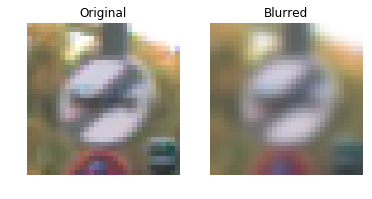

In [75]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blur(X_train[100],5))
plt.title("Blurred")
plt.axis('off')
plt.show()

#### 6. Translating the image
<font color="Green">Some of the images have the sign not in the center, so randomly moving the image a little could help.

In [8]:
def img_translation(img, trans_val):
    rows, cols, ch = img.shape
    x = trans_val * np.random.uniform() - trans_val / 2
    y = trans_val * np.random.uniform() - trans_val / 2
    M = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, M, (cols, rows))

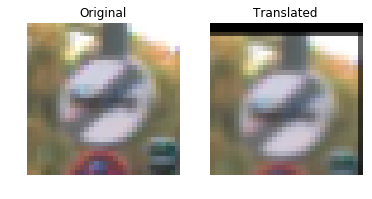

In [85]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_translation(X_train[100],10))
plt.title("Translated")
plt.axis('off')
plt.show()

#### 7. Rotating the image
<font color="green">Same logic applies here. 

In [9]:
def img_rotation(img, rot_val):
    rows, cols, ch = img.shape
    rot = rot_val * np.random.uniform() - rot_val / 2
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rot, 1)
    return cv2.warpAffine(img, M, (cols, rows))

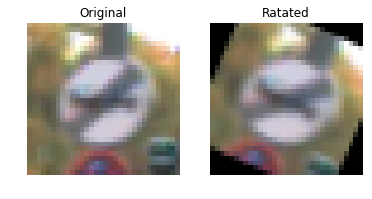

In [90]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_rotation(X_train[100],50))
plt.title("Ratated")
plt.axis('off')
plt.show()

#### 8. Affine Transformation
<font color="green">Similarly, applying affine transformation could help also. <font>

In [10]:
def img_at(img, aff_val):
    rows, cols, ch = img.shape
    pts1 = np.float32([[4, 4], [20, 4], [4, 20]])
    pt1 = 4 + aff_val * np.random.uniform() - aff_val / 2
    pt2 = 20 + aff_val * np.random.uniform() - aff_val / 2
    pts2 = np.float32([[pt1, 4], [pt2, pt1], [4, pt2]])
    M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(img, M, (cols, rows))

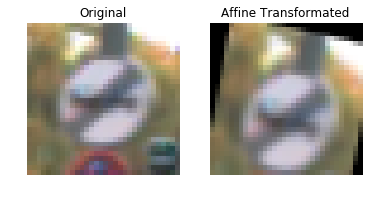

In [96]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[100])
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_at(X_train[100],20))
plt.title("Affine Transformated")
plt.axis('off')
plt.show()

#### Put together

In [11]:
def augment_img(X, label, X_out, Y_out, crop_val, k_value, trans_range, rot_range, aff_val, data_range):
    for i in range(len(X)):
        for j in range(data_range):
            img = X[i]
            # img = img_normalize(img)
            img = crop(img, crop_val)
            img = gaussian_blur(img, k_value)                        
            img = img_translation(img, trans_range)
            img = img_rotation(img, rot_range)
            img = img_at(img, aff_val)
            X_out.append(img)
            Y_out.append(label[i])

Generate more data

In [12]:
X_train_new = []
Y_train_new = []
augment_img(X_train, y_train, X_train_new, Y_train_new, 3, 5, 5, 20, 10, 10)
X_train = np.array(X_train_new)
y_train = np.array(Y_train_new)

X_valid_new = []
Y_valid_new = []
augment_img(X_valid, y_valid, X_valid_new, Y_valid_new, 3, 5, 5, 20, 10, 1)
X_valid = np.array(X_valid_new)
y_valid = np.array(Y_valid_new)

In [13]:
# Combine both the Training and Validation Dataset
# X_train = np.concatenate((X_train, X_valid), axis=0)
# y_train = np.concatenate((y_train, y_valid), axis=0)

# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Model Architecture

<font color="green">The LeNet architecture is really hard to manipulate, since I have to correct each input and output dimension individually for all the layers. So I leared to create each layer as a function with parameters passing in. The Architecture I am using is following the [GoogleLeNet](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf). My architecture incluces two [inception module](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337). And the input is 26x26x3 image and out put is 1x43 classes. The detail of the inception model can be found from the Andrew Ng's Convolution NN lecture Week 3 & 4, but the general idea is "why choose trail them all". So instead of returning one convolution output each layer, the inception model tral 4 convolutions, and then concatimate then together. 

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

# EPOCHS = 15
# BATCH_SIZE = 128

# def LeNet(x,):    
#     # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
#     mu = 0
#     sigma = 0.1
    
#     # TODO: Layer 1: Convolutional. Input = 32x32x. Output = 28x28x6.
#     conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,6)))
#     conv1_b = tf.Variable(tf.zeros(6))
#     conv1   = tf.nn.conv2d(x, filter=conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b
#     # TODO: Activation.
#     conv1 = tf.nn.relu(conv1)
#     # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
#     conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
#     # TODO: Layer 2: Convolutional. Output = 10x10x16.
#     conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
#     conv2_b = tf.Variable(tf.zeros(16))
#     conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
#     # TODO: Activation.
#     conv2 = tf.nn.relu(conv2)
#     # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
#     conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     # TODO: Flatten. Input = 5x5x16. Output = 400.
#     fc0   = flatten(conv2)
#     # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
#     fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
#     fc1_b = tf.Variable(tf.zeros(120))
#     fc1   = tf.matmul(fc0, fc1_W) + fc1_b
#     # TODO: Activation.
#     fc1    = tf.nn.relu(fc1)
#     # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
#     fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
#     fc2_b  = tf.Variable(tf.zeros(84))
#     fc2    = tf.matmul(fc1, fc2_W) + fc2_b
#     # TODO: Activation.
#     fc2    = tf.nn.relu(fc2)
#     # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
#     fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
#     fc3_b  = tf.Variable(tf.zeros(43))
#     logits = tf.matmul(fc2, fc3_W) + fc3_b
#     return logits

#### Define Convolution Layer

In [16]:
def conv_layer(x, filter_w, in_d, out_d):
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_w, filter_w, in_d, out_d), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(out_d))
    conv_res   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    return conv_res

def conv_relu_layer(x, filter_w, in_d, out_d):
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_w, filter_w, in_d, out_d), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(out_d))
    conv_res   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    return tf.nn.relu(conv_res)

#### Define Max Pooling Layer

In [17]:
def maxpool_layer(x, filter_w):
    return tf.nn.max_pool(x,ksize=[1,filter_w,filter_w,1], strides=[1,1,1,1],padding='SAME')

def maxpool_stride_layer(x, filter_w, s):
    return tf.nn.max_pool(x,ksize=[1,filter_w,filter_w,1], strides=[1,s,s,1],padding='VALID')

#### Define Fully Connected Layer

In [18]:
def fc_layer(x, a, b):
    fc_W = tf.Variable(tf.truncated_normal(shape=(a, b), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(b))
    fc = tf.matmul(x, fc_W) + fc_b
    return tf.nn.relu(fc)

#### Define Inception Module

In [19]:
def inception_module(x, in_d, out_d):
    conv1x1 = conv_layer(x, 1, in_d, out_d)
    conv2 = conv_relu_layer(x, 1, in_d, d_1x1)
    conv3 = conv_relu_layer(x, 1, in_d, d_1x1)
    maxpool = maxpool_layer(x, 3)
    conv_maxpool = conv_layer(maxpool, 1, in_d, out_d)
    conv3x3 = conv_layer(conv2, 3, d_1x1, int(out_d/2))
    conv3x3 = conv_layer(conv3x3, 1, int(out_d/2), out_d)
    conv5x5 = conv_layer(conv3, 5, d_1x1, int(out_d/2))
    conv5x5 = conv_layer(conv5x5, 1, int(out_d/2), out_d)
    return tf.nn.relu(tf.concat(3, [conv1x1, conv3x3, conv5x5, conv_maxpool]))

In [20]:
mu = 0.0
sigma = 0.1
dropout = 0.5
d_1 = 64
d_2 = 128
d_1x1 = 32
def GoogLeNet(x, out=43):    
    conv1 = conv_relu_layer(x, 1, 3, 3) #26x26x3
    conv2 = conv_relu_layer(conv1, 5, 3, 64) #26x26x32
    incept1 = inception_module(conv2, 64, d_1) #26x26x256
    maxpool1 = maxpool_stride_layer(incept1, 2, 2) #13x13x256
    incept2 = inception_module(maxpool1, d_1*4, d_2) #13x13x512
    maxpool2 = maxpool_stride_layer(incept2, 3, 2) #6x6x512
    conv3 = conv_layer(maxpool2, 1, 512, 256) #6x6x256
    fc0 = flatten(conv3)
    fc1 = fc_layer(fc0, 256*6*6, 512)
    fc1 = tf.nn.dropout(fc1, keep_prob)     
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, out), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(out))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

### Train, Validate and Test the Model

In [21]:
# Features and Labels
EPOCHS = 15
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 26, 26, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

# Training Pipeline
rate = 0.0005

logits = GoogLeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
# Train the Model
import time
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            tr, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y,  keep_prob: dropout})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if offset:
            print(offset, loss, validation_accuracy)
            print("Time :", time.time() - start_time)
            start_time = time.time()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.865

347904 0.342101 0.86507936462
Time : 691.20583152771
EPOCH 2 ...
Validation Accuracy = 0.936

347904 0.0363199 0.936281178436
Time : 691.0893447399139
EPOCH 3 ...
Validation Accuracy = 0.947

347904 0.0712469 0.947165532177
Time : 690.8814854621887
EPOCH 4 ...
Validation Accuracy = 0.948

347904 0.0493176 0.948072562412
Time : 690.0104074478149
EPOCH 5 ...
Validation Accuracy = 0.963

347904 0.0305634 0.963265305906
Time : 689.8874082565308
EPOCH 6 ...
Validation Accuracy = 0.961

347904 0.111832 0.960997732453
Time : 689.5259835720062
EPOCH 7 ...
Validation Accuracy = 0.966

347904 0.000916747 0.966213152198
Time : 689.2176649570465
EPOCH 8 ...
Validation Accuracy = 0.968

347904 0.0344499 0.967800453785
Time : 689.1032917499542
EPOCH 9 ...
Validation Accuracy = 0.967

347904 0.028065 0.966893423793
Time : 688.8614256381989
EPOCH 10 ...
Validation Accuracy = 0.965

347904 0.0117419 0.964625850448
Time : 688.6451120376587
EPOCH 11 .

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Test Dataset generation
X_test_new = []
Y_test_new = []
augment_img(X_test, y_test, X_test_new, Y_test_new, 3, 5, 5, 20, 10, 1)
X_test = np.array(X_test_new)
y_test = np.array(Y_test_new)

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

Train Accuracy = 0.997


In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    valid_accuracy = evaluate(X_valid, y_valid)
    print("Train Accuracy = {:.3f}".format(valid_accuracy))

Train Accuracy = 0.972


In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.957


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

For this part, I googled for best visible signs from the German Road Sign, and someone on the internet has already pick the best one for testing, which could give the better performance.

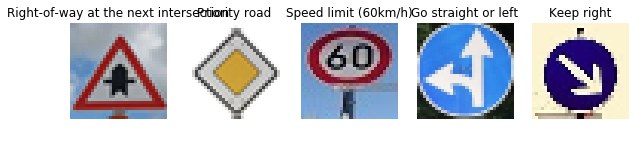

New test data dim: (5, 32, 32, 3)


In [59]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob

New_images = []
for _, imp in enumerate(glob.glob('./test/*.png')):
    img=cv2.imread(imp, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    New_images.append(np.array(img, dtype='uint8'))
New_images = np.array(New_images)

New_labels = [11, 12, 3, 37, 38]

plt.figure(figsize=(10, 3))
for i in range(len(New_images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(New_images[i])
    plt.title(SignName[New_labels[i]])
    plt.axis('off')
plt.show()
print("New test data dim: " + str(New_images.shape))

### Predict the Sign Type for Each Image

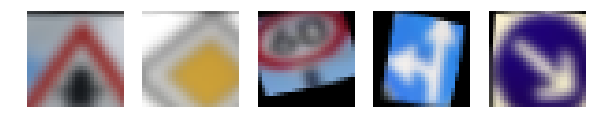

In [61]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_new=[]
Y_new=[]
augment_img(New_images, New_labels, X_new, Y_new, 3, 5, 5, 20, 10, 1)
X_new = np.array(X_new)
Y_new = np.array(Y_new)

plt.figure(figsize=(10, 3))
for i in range(len(X_new)):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_new[i])
    #plt.title(sign)
    plt.axis('off')
plt.show()

In [62]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    new_accuracy = evaluate(X_new, Y_new)
    print("New Dataset Accuracy = {:.3f}".format(new_accuracy))

New Dataset Accuracy = 1.000


### Analyze Performance

In [63]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("the accuracy is 100% for the new images")

the accuracy is 100% for the new images


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

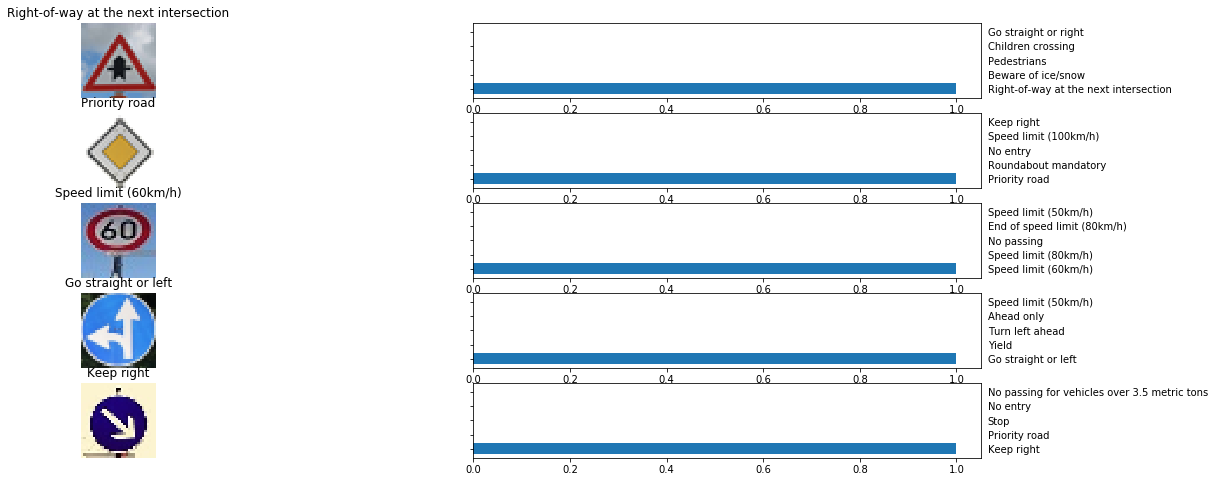

In [82]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    new_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_new, keep_prob: 1.0})
    new_top_k = sess.run(top_k, feed_dict={x: X_new, keep_prob: 1.0})


plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(New_images[i]) 
    plt.title(SignName[New_labels[i]])
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), new_top_k.values[i, :])
    labs=[SignName[j] for j in new_top_k.indices[i]]
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [129]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
import matplotlib.pyplot as plt
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, row_n=8, col_n=8):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    print('Activation ',tf_activation)
    featuremaps = activation.shape[3]
    print(str(featuremaps) + " outputs")
    if featuremaps > 64:
        featuremaps = 64
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(row_n, col_n, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

#### Convolution Layer 1

Layer 1: convolution 1
Activation  Tensor("Relu_62:0", shape=(?, 26, 26, 3), dtype=float32)
3 outputs


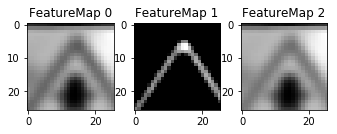

In [134]:
conv1 = conv_relu_layer(x, 1, 3, 3) #26x26x3
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 1: convolution 1")
    outputFeatureMap(X_new, conv1)

#### Convolution Layer 2

Layer 2: convolution 2
Activation  Tensor("Relu_63:0", shape=(?, 26, 26, 64), dtype=float32)
64 outputs


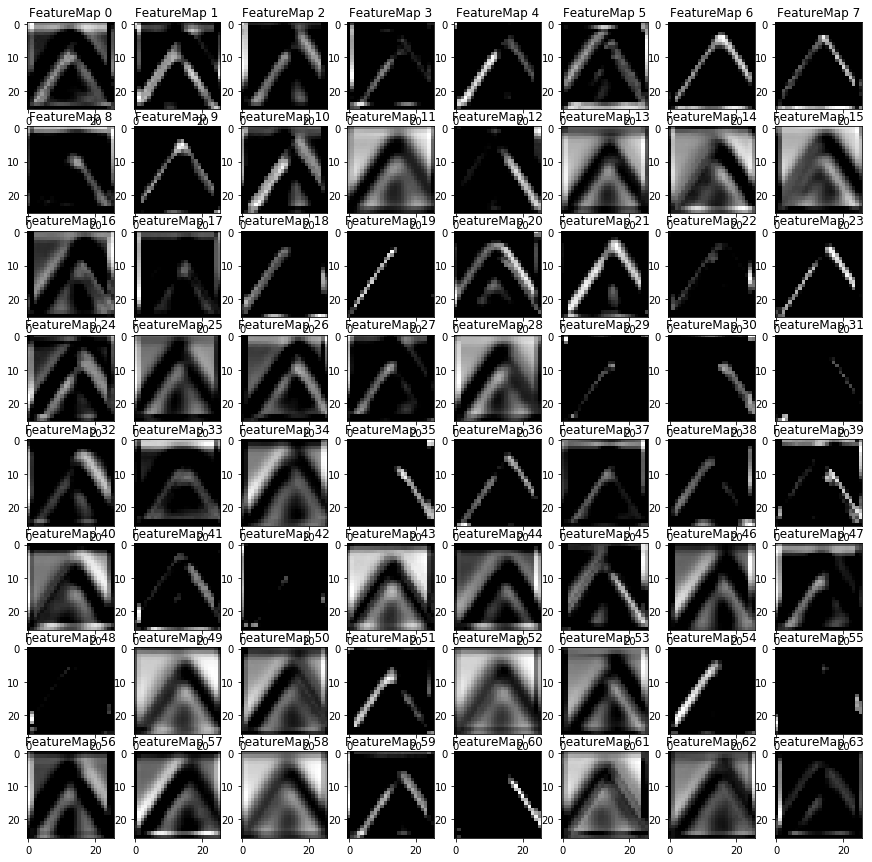

In [135]:
conv2 = conv_relu_layer(conv1, 5, 3, 64) #26x26x64
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 2: convolution 2")
    outputFeatureMap(X_new, conv2)

#### Layer 3: Inception 1 + Max Pooling 1

Layer 3: inception 1
Activation  Tensor("Relu_81:0", shape=(?, 26, 26, 256), dtype=float32)
256 outputs


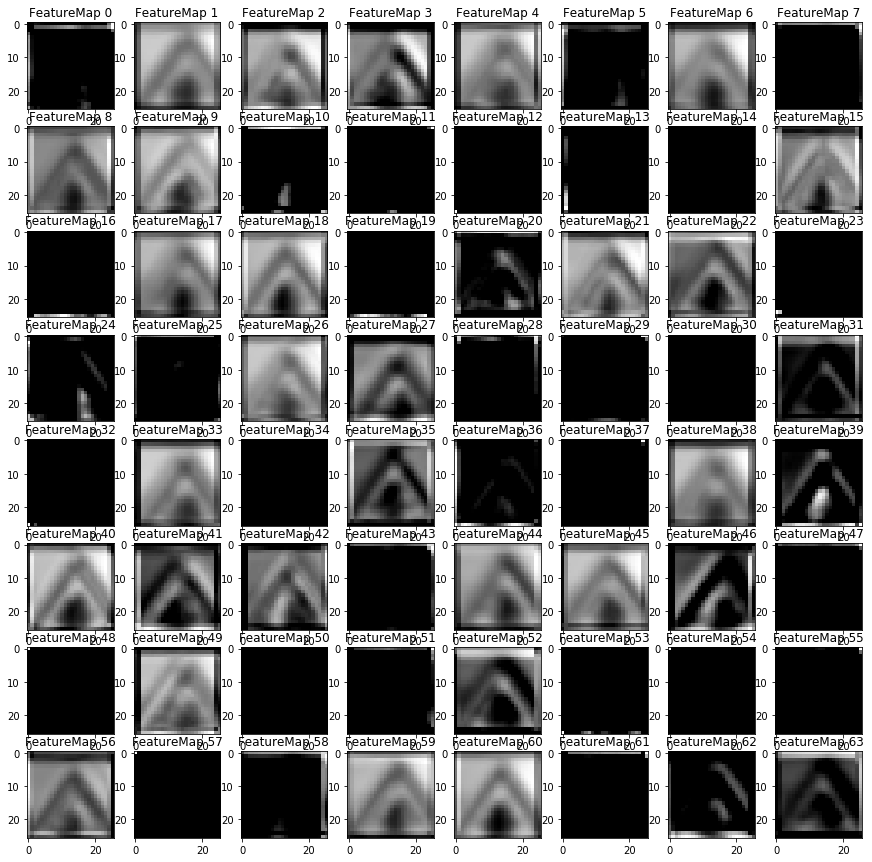

In [141]:
incept1 = inception_module(conv2, 64, d_1) #26x26x256
maxpool1 = maxpool_stride_layer(incept1, 2, 2) #13x13x256

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 3: inception 1")
    outputFeatureMap(X_new, incept1)

Layer 3: maxpool 1
Activation  Tensor("MaxPool_37:0", shape=(?, 13, 13, 256), dtype=float32)
256 outputs


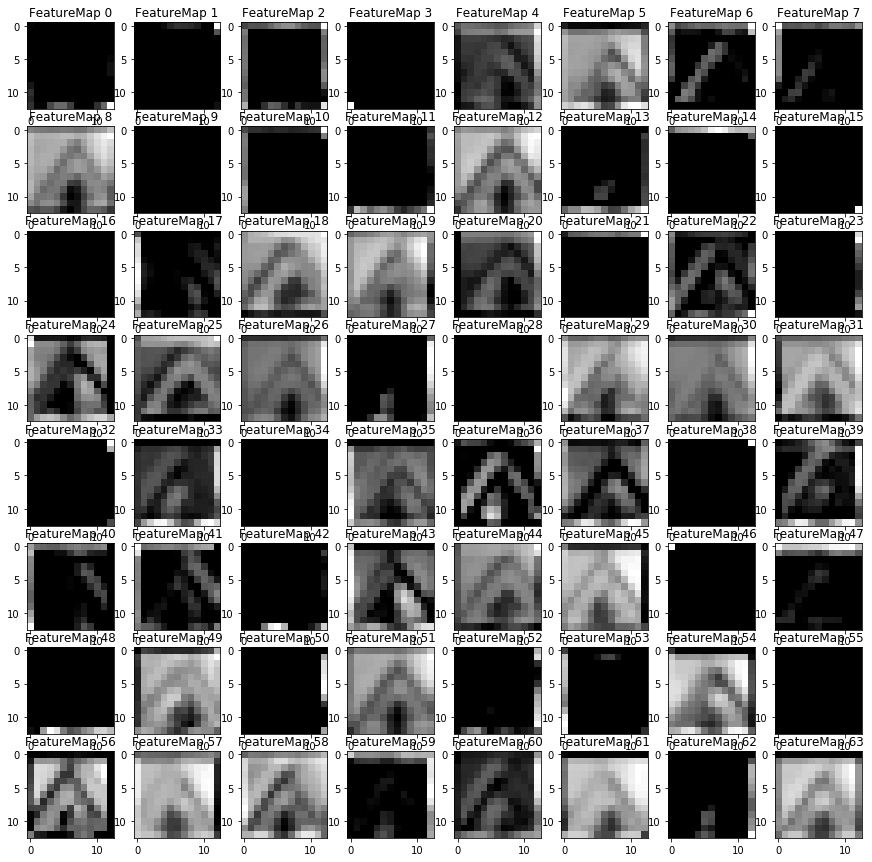

In [142]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 3: maxpool 1")
    outputFeatureMap(X_new, maxpool1)

#### Layer 4: Inception 2 + Max Pooling 2

Layer 4: inception 2
Activation  Tensor("Relu_72:0", shape=(?, 13, 13, 512), dtype=float32)
512 outputs


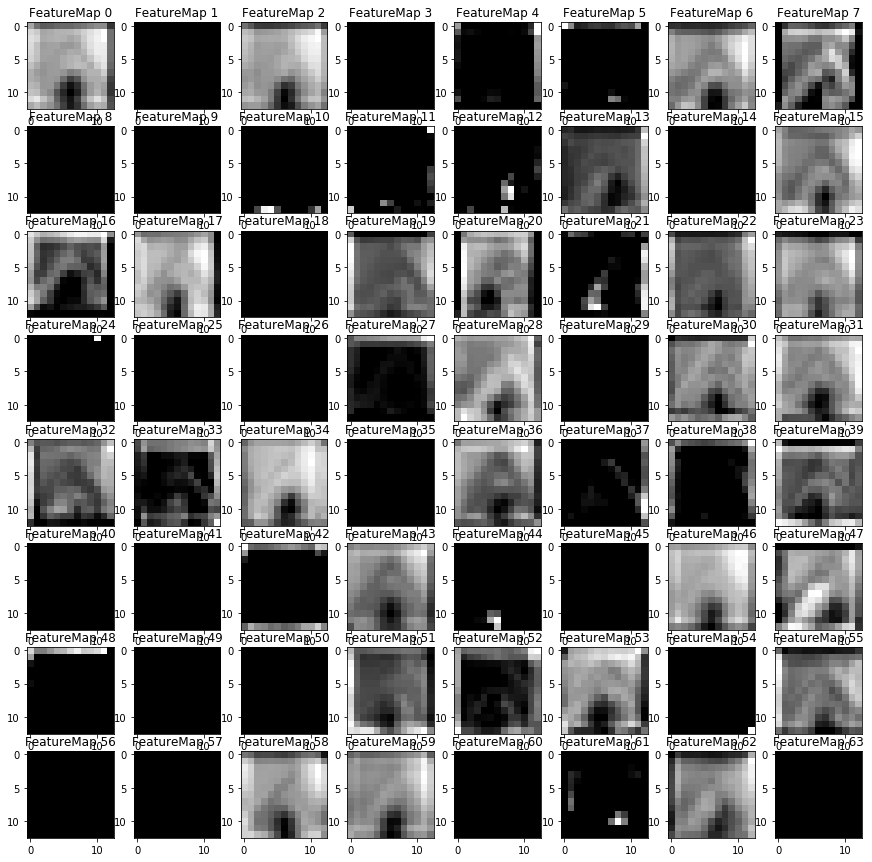

In [138]:
incept2 = inception_module(maxpool1, d_1*4, d_2) #13x13x512
maxpool2 = maxpool_stride_layer(incept2, 3, 2) #6x6x512
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 4: inception 2")
    outputFeatureMap(X_new, incept2)

Layer 4: maxpool 2
Activation  Tensor("MaxPool_31:0", shape=(?, 6, 6, 512), dtype=float32)
512 outputs


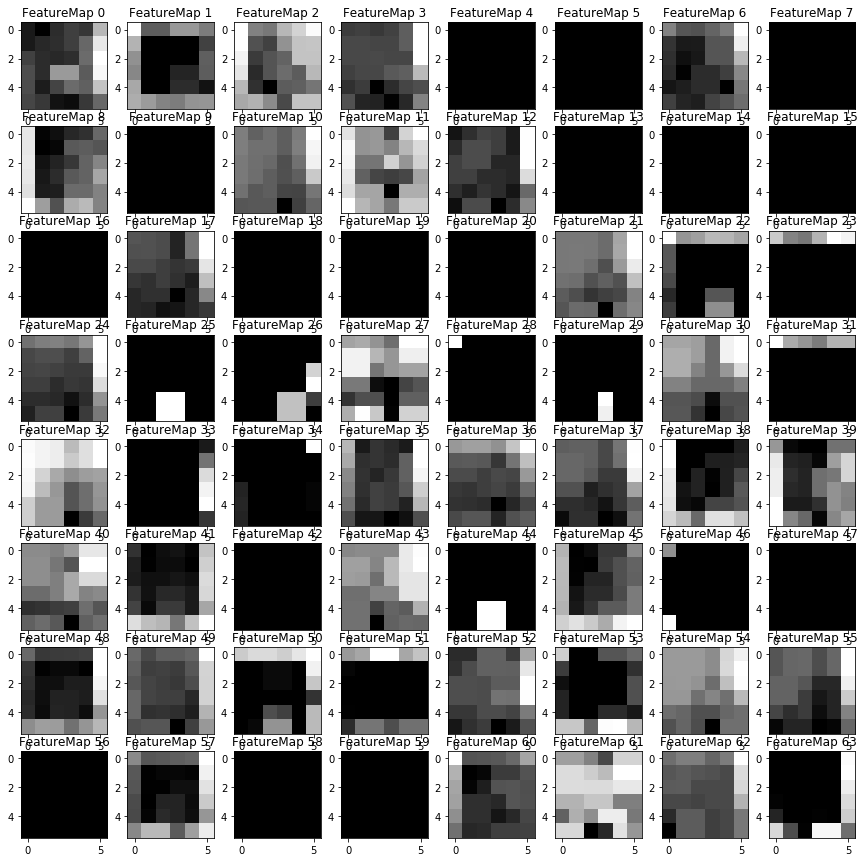

In [143]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 4: maxpool 2")
    outputFeatureMap(X_new, maxpool2)

#### Layer 5: Convolution 3

Layer 5: convolution 3
Activation  Tensor("add_164:0", shape=(?, 6, 6, 256), dtype=float32)
256 outputs


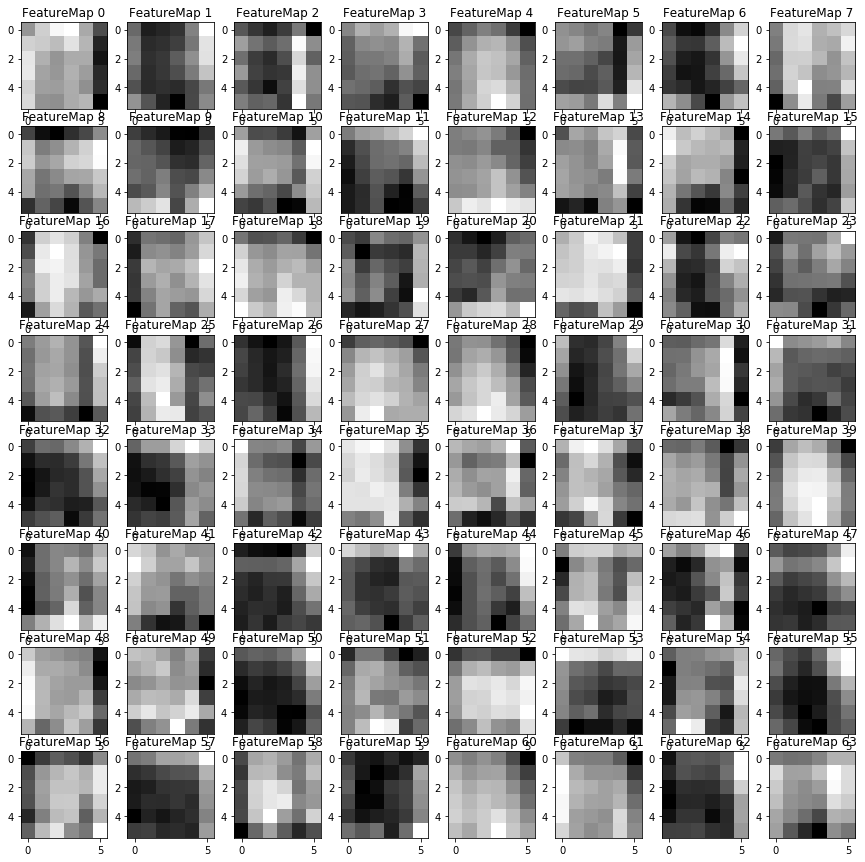

In [144]:
conv3 = conv_layer(maxpool2, 1, 512, 256)  
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    print("Layer 5: convolution 3")
    outputFeatureMap(X_new, conv3)